In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('../data/final_dataset.csv')
df.head()

,words,sentence #,tag
0,FOB,0,O
1,MULTI,0,O
2,CODES,0,O
3,DENIM,0,O
4,FABRIC,0,O


In [3]:
len(set(df.words)), len(df)

(8819, 62354)

In [4]:
words = list(set(df["words"].values))
words.append("ENDPAD")
n_words = len(words)
words[-1], n_words

('ENDPAD', 8820)

In [5]:
tags = list(set(df['tag'].values))
n_tags = len(tags)
tags, n_tags

(['B-NW', 'O', 'I-NW'], 3)

In [6]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 0
        self.data = df
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["words"].values.tolist(),
                                                     s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
getter = SentenceGetter(df)
getter.get_next()
print(getter.get_next())

[('CPT', 'O'), ('LAHORE', 'O'), ('AIRPORT', 'O'), ('PAKISTAN', 'O'), ('PHARMACEUTICAL', 'O'), ('ALLOPATHIC', 'O'), ('RAW', 'O'), ('MATERIAL', 'O'), ('OF', 'O'), ('PHARMACEUTICAL', 'O'), ('GRADE', 'O'), ('QTY', 'O'), ('100', 'B-NW'), ('KGS', 'I-NW'), ('TRAMADOL', 'O'), ('HCL', 'O'), ('BP/EP', 'O'), ('AT', 'O'), ('USD', 'O'), ('45', 'O'), ('PER', 'O'), ('KG.', 'O'), ('AS', 'O'), ('PER', 'O'), ("BENEFICIARY'S", 'O'), ('PROFORMA', 'O'), ('INVOICE', 'O'), ('NO.', 'O'), ('SLS235/2019', 'O'), ('DATED', 'O'), ('22112019', 'O')]


In [8]:
sentences = getter.sentences

In [9]:
print(sentences[0])
len(sentences)

[('FOB', 'O'), ('MULTI', 'O'), ('CODES', 'O'), ('DENIM', 'O'), ('FABRIC', 'O'), ('AS', 'O'), ('PER', 'O'), ('PROFORMA', 'O'), ('INVOICE', 'O'), ('NO.', 'O'), ('HTX0300/2018', 'O'), ('DATED', 'O'), ('01.12.18', 'O')]


1719

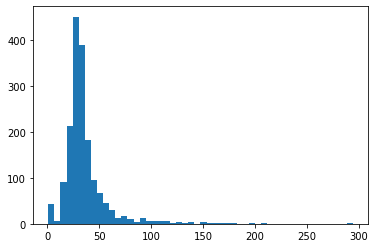

In [10]:
import matplotlib.pyplot as plt

plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [11]:
max_len = 50
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [12]:
word2idx['FOB'], tag2idx['B-NW']

(4533, 0)

In [13]:
from keras.preprocessing.sequence import pad_sequences

X = [[word2idx[w[0]] for w in s] for s in sentences]

In [14]:
X

[[4533, 496, 1631, 4745, 4846, 245, 5429, 3464, 8506, 1370, 3084, 7724, 4932],
 [851,
  1542,
  518,
  5891,
  934,
  2399,
  3726,
  3741,
  2423,
  934,
  6064,
  3644,
  6927,
  8379,
  8556,
  8510,
  2619,
  8384,
  6286,
  5627,
  5429,
  6646,
  245,
  5429,
  2650,
  3464,
  8506,
  1370,
  3236,
  7724,
  1840],
 [1351,
  5744,
  4200,
  4163,
  6060,
  5891,
  3644,
  7767,
  2483,
  2423,
  7800,
  3930,
  8322,
  7278,
  6916,
  7187,
  3286,
  8384,
  6286,
  1320,
  5429,
  1505,
  1801,
  7498,
  245,
  5429,
  2650,
  7959,
  1370,
  2826,
  7724,
  5508],
 [1351,
  6223,
  2544,
  2423,
  4200,
  7418,
  6970,
  5460,
  5405,
  3114,
  0,
  3281,
  6367,
  5110,
  5405,
  3281,
  7623,
  5110,
  245,
  5429,
  2650,
  3464,
  8506,
  1370,
  4697,
  7724,
  7845],
 [851,
  1542,
  518,
  5891,
  7850,
  3644,
  7850,
  6628,
  7463,
  1298,
  7486,
  146,
  850,
  8384,
  6323,
  44,
  6286,
  8797,
  5429,
  6628,
  8564,
  7498,
  245,
  5429,
  2650,
  3464,
  8506,

In [15]:
# so we have the same length
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

In [16]:
print(X[1])

[ 851 1542  518 5891  934 2399 3726 3741 2423  934 6064 3644 6927 8379
 8556 8510 2619 8384 6286 5627 5429 6646  245 5429 2650 3464 8506 1370
 3236 7724 1840 8819 8819 8819 8819 8819 8819 8819 8819 8819 8819 8819
 8819 8819 8819 8819 8819 8819 8819 8819]


In [17]:
X.shape

(1719, 50)

In [18]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [19]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [20]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [21]:
print(y[1])

[1 1 1 1 1 1 1 1 1 1 1 1 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [22]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [25]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)  # 50-dim embedding
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)  # variational biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

Metal device set to: Apple M1 Pro


2022-06-15 14:59:31.313268: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-15 14:59:31.313603: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [26]:
model = Model(input, out)

In [27]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [28]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Epoch 1/5


2022-06-15 14:59:31.658014: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-15 14:59:33.157360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - ETA: 0s - loss: 0.2557 - accuracy: 0.9358

2022-06-15 15:04:38.235251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 308s 8s/step - loss: 0.2557 - accuracy: 0.9358 - val_loss: 0.1766 - val_accuracy: 0.9559
Epoch 2/5
39/39 [==============================] - 303s 8s/step - loss: 0.1582 - accuracy: 0.9577 - val_loss: 0.1542 - val_accuracy: 0.9559
Epoch 3/5
39/39 [==============================] - 297s 8s/step - loss: 0.1201 - accuracy: 0.9583 - val_loss: 0.1033 - val_accuracy: 0.9562
Epoch 4/5
39/39 [==============================] - 293s 8s/step - loss: 0.0603 - accuracy: 0.9810 - val_loss: 0.0459 - val_accuracy: 0.9865
Epoch 5/5
39/39 [==============================] - 294s 8s/step - loss: 0.0300 - accuracy: 0.9922 - val_loss: 0.0296 - val_accuracy: 0.9916


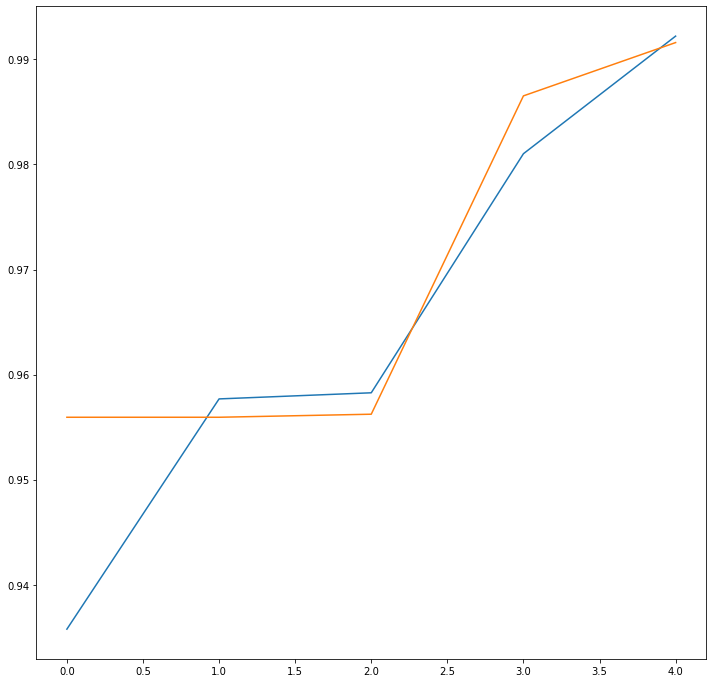

In [30]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()